# Create simple similarity pipeline

In [458]:
import os
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import json
from time import time
from tqdm import tqdm
from scipy.spatial.distance import cosine
import csv
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torchsummary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


from vectorizing_scripts import *

%load_ext autoreload
%autoreload 2

dataset_path = "datasets"
train_path = os.path.join(dataset_path, "train.csv")
test_path = os.path.join(dataset_path, "test.csv")
submission_path = os.path.join(dataset_path, "sample_submission.csv")



processed_contexts_path = os.path.join(dataset_path, "processed_contexts.json")
processed_contexts = read_json(processed_contexts_path)

train_dataset = pd.read_csv(train_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# #problems patents ids
#
# count_cont = 0
# for key in processed_contexts:
#     #if len(processed_contexts[key]) < 100:
#     len_train = len(train_dataset.loc[train_dataset.context == key])
#     len_cont = len(processed_contexts[key])
#     print(key, len_cont, len_train)
#     count_cont += len_cont

G01 9908 1812
A47 3698 418
F04 1910 293
F21 841 111
B23 4123 648
G03 3273 548
C07 6863 1069
C03 1474 163
A45 858 118
C10 2579 601
B24 755 214
F02 3495 566
B61 925 294
E03 427 148
A23 2065 102
F28 663 111
B31 568 24
F16 7469 1091
H02 2416 536
D06 1966 259
C21 511 88
H01 20312 2186
F24 1584 257
B33 12 0
F25 1527 68
G02 2325 877
G99 2 0
H03 4469 798
H04 9701 2177
A01 2908 637
B65 9021 764
B22 994 347
H05 2230 498
G04 1011 307
A61 13166 1477
B60 8106 916
F01 2189 406
B99 2 0
B62 1538 321
C14 124 56
A63 3496 524
G16 126 54
C05 139 0
E02 970 170
B21 1689 306
F23 1679 226
B27 573 154
A43 706 203
C01 1965 350
D99 2 0
G10 1303 82
E01 1044 236
E05 2141 228
B44 222 105
C12 10337 633
B29 6621 593
G21 562 112
E04 2571 400
F42 529 147
G07 786 126
B02 362 63
B04 147 0
C08 5076 649
Y02 339 0
C09 3468 553
B63 1459 170
B43 421 0
B25 1011 140
C06 181 61
B41 2650 650
B08 208 69
B68 122 0
G06 5021 1063
A41 648 166
B66 1010 239
B81 451 57
C22 691 110
F41 1007 144
D07 446 0
D21 834 300
F17 653 33
B64 1065 17

In [3]:
# count_cont

261041

## Vectorize and dump contexts dataset

In [4]:
# test_dataset = {}
# test_dataset["F21"] = processed_contexts["F21"]
# test_dataset["B24"] = processed_contexts["B24"]
#
# device = "cpu"
# model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
# vectorized_path = "vectorized_dumps"
# name_for_dump = os.path.join(vectorized_path, "test_dump.json")
#
# vect_class_1 = VectorizeContexts()
# vect_class_1.load_model(model_name, device)
# vect_class_1.vectorize(test_dataset)
# vect_class_1.dump_vectorized_dataset(name_for_dump)
#
# vect_class_2 = VectorizeContexts()
# vectorized_dataset = vect_class_2.load_vectorized_dataset(name_for_dump)

In [5]:
# device = "cpu"
# model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
# vectorized_path = "vectorized_dumps"
# name_for_dump = os.path.join(vectorized_path, "processed_contexts_dump.json")
#
# #vectorize and dump full data
# vect_class = VectorizeContexts()
# vect_class.load_model(model_name, device)
# vect_class.vectorize(processed_contexts)
# vect_class.dump_vectorized_dataset(name_for_dump)

## Small test

In [4]:
# vectorized_path = "vectorized_dumps"
# name_for_dump = os.path.join(vectorized_path, "processed_contexts_dump.json")
# vect_class = VectorizeContexts()
# vectorized_dataset = vect_class.load_vectorized_dataset(name_for_dump)
#
# test_dataset = {}
# test_dataset["F21"] = processed_contexts["F21"]
# test_dataset["B24"] = processed_contexts["B24"]
#
# test_vectorized_dataset = {}
# test_vectorized_dataset["F21"] = vectorized_dataset["F21"]
# test_vectorized_dataset["B24"] = vectorized_dataset["B24"]
#
# print(test_vectorized_dataset.keys())
#
# context = "F21"
# index = Index()
# texts_for_context = test_dataset[context]
# vectors_for_context = test_vectorized_dataset[context]
#
# index.fill_index(texts_for_context, vectors_for_context)
#
# list_of_targets = train_dataset.loc[train_dataset.context == "F21"].target.to_list()
#
# list_of_anchors = train_dataset.loc[train_dataset.context == "F21"].anchor.to_list()
#
# device = "cpu"
# model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
#
# single_target = list_of_targets[1]
# single_anchor = list_of_anchors[1]
#
# vect_class_single = VectorizeContexts()
# vect_class_single.load_model(model_name, device)
#
# vect_of_target = vect_class_single.vectorize_single_text(single_target)
# vect_of_anchor = vect_class_single.vectorize_single_text(single_anchor)
#
# n_of_answers = 100
#
# ret_target = index.retrieval(vect_of_target, n_of_answers)[0]
# ret_anchor = index.retrieval(vect_of_anchor, n_of_answers)[0]
#
# print(get_intersections_count(ret_target, ret_anchor))
# print(get_intersections_count(ret_target, ret_anchor))
# print(cosine(vect_of_target, vect_of_anchor))

In [18]:
vectorized_path = "vectorized_dumps"
name_for_dump = os.path.join(vectorized_path, "processed_contexts_dump.json")
vect_class = VectorizeContexts()
vectorized_dataset = vect_class.load_vectorized_dataset(name_for_dump)

In [9]:
X = train_dataset[["id", "anchor", "target", "context"]]
y = train_dataset["score"]


1

In [12]:
device = "cuda:0"
model_name = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
n_of_answers = 100

vect_class_single = VectorizeContexts()
vect_class_single.load_model(model_name, device)


In [63]:
# np.savetxt("datasets/x_train_features.csv", X_train_fratures, delimiter=",")
#
# with open("datasets/x_train_features.csv", "r") as fin:
#     X_train_fratures_loaded = list(csv.reader(fin, delimiter=","))
#
# X_train_fratures_loaded = np.array(X_train_fratures_loaded, dtype="float64")


In [67]:
# X_features = create_features(X, vect_class_single, processed_contexts, vectorized_dataset, n_of_answers)

36473it [14:39, 41.46it/s]


execution time: 879.8397924900055


In [68]:
np.savetxt("datasets/x_features.csv", X_features, delimiter=",")

with open("datasets/x_features.csv", "r") as fin:
    X_features_loaded = list(csv.reader(fin, delimiter=","))

X_features_loaded = np.array(X_features_loaded, dtype="float64")

## Analyze obtained features

<AxesSubplot:>

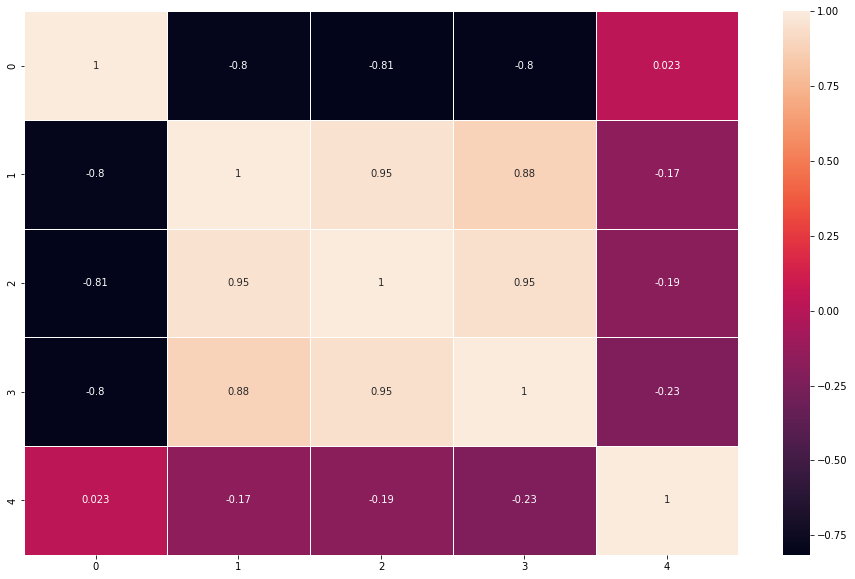

In [85]:
corr_matr = np.corrcoef(X_features_loaded, rowvar=False)
plt.figure(figsize = (16,10))
sns.heatmap(corr_matr, annot=True, linewidth=0.5)

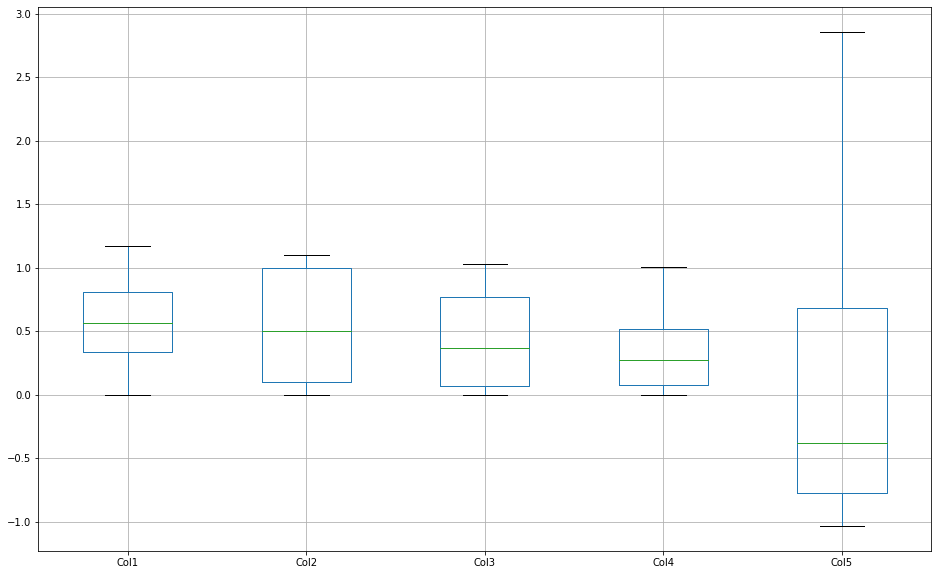

In [88]:
df = pd.DataFrame(X_features_loaded,
                  columns=['Col1', 'Col2', 'Col3', 'Col4', "Col5"])
plt.figure(figsize = (16,10))
boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3', 'Col4', "Col5"])

Good question: why feature at Col1 > 1? This is cosine function between two vectors. So, it should be in range [0, 1]. 0, if two vectors are similar, and 1 in another case.

## LightGBM classifier

In [346]:
#setting up the parameters
params={}
params['learning_rate'] = 0.03
params['boosting'] = 'gbdt' #GradientBoostingDecisionTree
params['objective'] = 'multiclass' #Multi-class target feature
#params['objective'] = 'regression'
params['metric'] = 'multi_logloss' #metric for multi-class
params['num_class'] = max(y) + 1
params["num_iterations"] = 100
params["num_leaves"] = 100
params['max_depth'] = 20
n_epochs = 10

y_dataset = train_dataset["score"]
y_to_class = np.array(y_dataset * 4, dtype=int)
y = y_to_class

with open("datasets/x_features.csv", "r") as fin:
    X_features_loaded = list(csv.reader(fin, delimiter=","))

X_features_loaded = np.array(X_features_loaded, dtype="float64")

X_train, X_test, y_train, y_test = train_test_split(X_features_loaded, y, test_size=0.2)

train_gbm = lgb.Dataset(X_train, label=y_train)
test_gbm = lgb.Dataset(X_test, label=y_test)

#training the model
clf = lgb.train(params, train_gbm, n_epochs)

y_pred_proba = clf.predict(X_test)
y_pred = [np.argmax(line) for line in y_pred_proba]

y_test_for_score = y_test / 4
y_pred_for_score = np.array(y_pred) / 4

# print("precision micro:", precision_score(y_test, y_pred, average="micro"))
# print("precision macro:", precision_score(y_test, y_pred, average="macro"))
# print("recall micro:", recall_score(y_test, y_pred, average="micro"))
# print("recall macro:", recall_score(y_test, y_pred, average="macro"))
# print("f1 micro:", f1_score(y_test, y_pred, average="micro"))
# print("f1 macro:", f1_score(y_test, y_pred, average="macro"))
# print("roc-auc:", roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovo"))

print()
score = pearsonr(y_test_for_score, y_pred_for_score)[0]
print("pearson score:", score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 29178, number of used features: 5
[LightGBM] [Info] Start training from score -1.583491
[LightGBM] [Info] Start training from score -1.152691
[LightGBM] [Info] Start training from score -1.085944
[LightGBM] [Info] Start training from score -2.209327
[LightGBM] [Info] Start training from score -3.454625

pearson score: 0.4976905730616627


## LighGBM regression

In [374]:
#setting up the parameters
params={}
params['learning_rate'] = 0.03
params['boosting'] = 'gbdt' #GradientBoostingDecisionTree
#params['objective'] = 'multiclass' #Multi-class target feature
params['objective'] = 'regression'
params["num_iterations"] = 100
params["num_leaves"] = 1000
params['max_depth'] = 400
n_epochs = 100

y_dataset = train_dataset["score"]
y = y_dataset

with open("datasets/x_features.csv", "r") as fin:
    X_features_loaded = list(csv.reader(fin, delimiter=","))

X_features_loaded = np.array(X_features_loaded, dtype="float64")

X_train, X_test, y_train, y_test = train_test_split(X_features_loaded, y, test_size=0.2)

train_gbm = lgb.Dataset(X_train, label=y_train)
test_gbm = lgb.Dataset(X_test, label=y_test)

#training the model
clf = lgb.train(params, train_gbm, n_epochs)

y_pred_proba = clf.predict(X_test)

print()
score = pearsonr(y_test_for_score, y_pred_proba)[0]
print("pearson score:", score)

/home/andrey/PycharmProjects/Kaggle/PatentPhrase/.venv/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 29178, number of used features: 5
[LightGBM] [Info] Start training from score 0.362011

pearson score: 0.006067339787395398


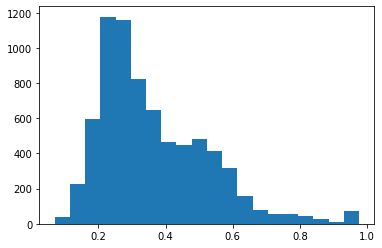

In [375]:
plt.hist(y_pred_proba, bins=20)
plt.show()

In [376]:
print(y_pred_proba)

[0.44689935 0.22384024 0.31616455 ... 0.30462884 0.76017435 0.46937506]


In [377]:
print(y_train)

26434    0.75
14870    0.75
11044    0.50
36291    0.00
2251     0.50
         ... 
1394     0.50
34515    0.50
24626    0.00
33347    0.75
12045    0.50
Name: score, Length: 29178, dtype: float64


In [379]:
list_of_bnds = np.array([0, 0.25, 0.5, 0.75, 1])
y_discr_pred = []
for el in y_pred_proba:
    bnds = np.abs(list_of_bnds - el)
    ind_of_el = np.argmin(bnds)
    el = list_of_bnds[ind_of_el]
    y_discr_pred.append(el)



In [381]:
score = pearsonr(y_test_for_score, y_discr_pred)[0]
print("pearson score:", score)

pearson score: 0.005146943634155682


## Neuron network example

In [580]:
input_shape = X_train.shape[1]
output_shape = 5
hidden_shape_1 = 50
hidden_shape_2 = 100
number_of_layers = 2

layers = []
layers.append(nn.Linear(input_shape, hidden_shape_1))
layers.append(nn.ReLU())
for i in range(number_of_layers):
    layers.append(nn.Linear(hidden_shape_1, hidden_shape_2))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_shape_2, hidden_shape_1))
    layers.append(nn.ReLU())

layers.append(nn.Linear(hidden_shape_1, output_shape))
layers.append(nn.Softmax())
model = nn.Sequential(*layers)

#torchsummary.summary(net, (input_shape,))

In [581]:
y = train_dataset["score"].to_numpy()
y = np.array(4 * y, dtype="int")

with open("datasets/x_features.csv", "r") as fin:
    X_features_loaded = list(csv.reader(fin, delimiter=","))

X_features_loaded = np.array(X_features_loaded, dtype="float64")

X_train, X_val, y_train, y_val = train_test_split(X_features_loaded, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)



In [582]:
class Data(Dataset):
    def __init__(self, X_train, y_train):
        x = np.array(X_train, dtype="float32")
        y = y_train
        #y = np.array(y_train, dtype="float32")
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)
        self.len = self.x.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_train = Data(X_train, y_train)
data_validation = Data(X_val, y_val)
data_test = Data(X_test, y_test)

pow_of_batch = 15
batch_size = 2 ** pow_of_batch
train_loader = DataLoader(dataset=data_train, batch_size=batch_size)
validation_loader = DataLoader(dataset=data_validation, batch_size=batch_size)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size)


In [585]:
epoch_number = 1000
device = "cuda:0"
net = TinyNeuralNetwork(device, model, need_weights_zeroing=False)
net.train(train_loader, validation_loader, epoch_number=epoch_number)

epoch: 1/1000
processing...
running time: 0.61
running loss: 1.41
train accuracy: 47.67
test accuracy: 47.25
train pearson: 33.99
test pearson: 34.58
epoch: 2/1000
processing...
running time: 0.78
running loss: 1.42
train accuracy: 48.63
test accuracy: 48.57
train pearson: 39.31
test pearson: 40.38
epoch: 3/1000
processing...
running time: 0.77
running loss: 1.41
train accuracy: 48.14
test accuracy: 47.83
train pearson: 45.92
test pearson: 46.59
epoch: 4/1000
processing...
running time: 0.72
running loss: 1.42
train accuracy: 48.03
test accuracy: 47.7
train pearson: 46.17
test pearson: 46.84
epoch: 5/1000
processing...
running time: 0.59
running loss: 1.42
train accuracy: 48.49
test accuracy: 48.27
train pearson: 43.52
test pearson: 44.32
epoch: 6/1000
processing...
running time: 0.95
running loss: 1.41
train accuracy: 48.66
test accuracy: 48.47
train pearson: 39.96
test pearson: 41.37
epoch: 7/1000
processing...
running time: 0.65
running loss: 1.41
train accuracy: 48.52
test accuracy

<Figure size 1152x720 with 0 Axes>

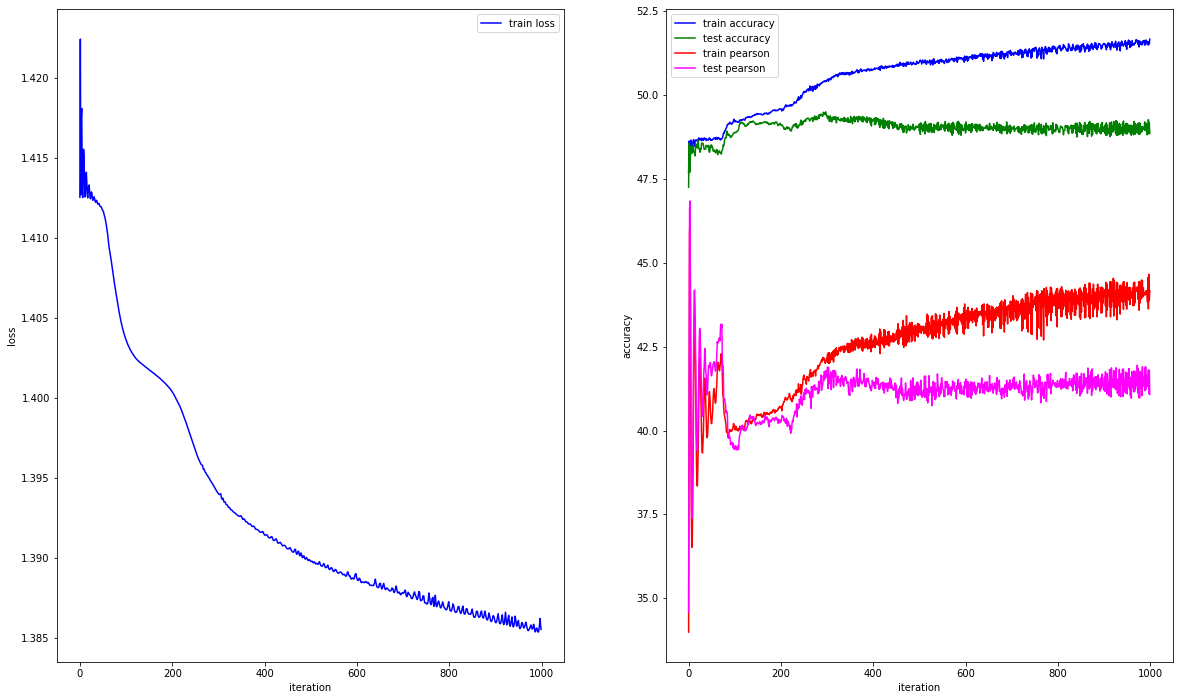

In [586]:
net.plot_train_history()

<Figure size 1152x720 with 0 Axes>

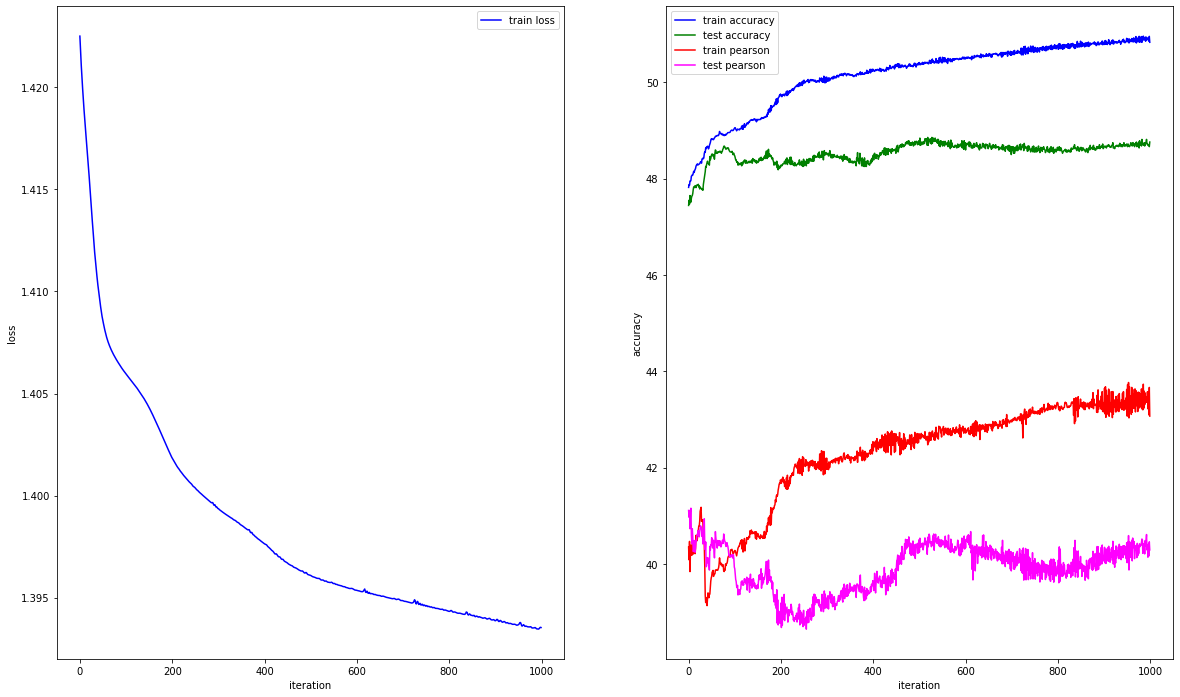

In [534]:
net.plot_train_history()

<Figure size 1152x720 with 0 Axes>

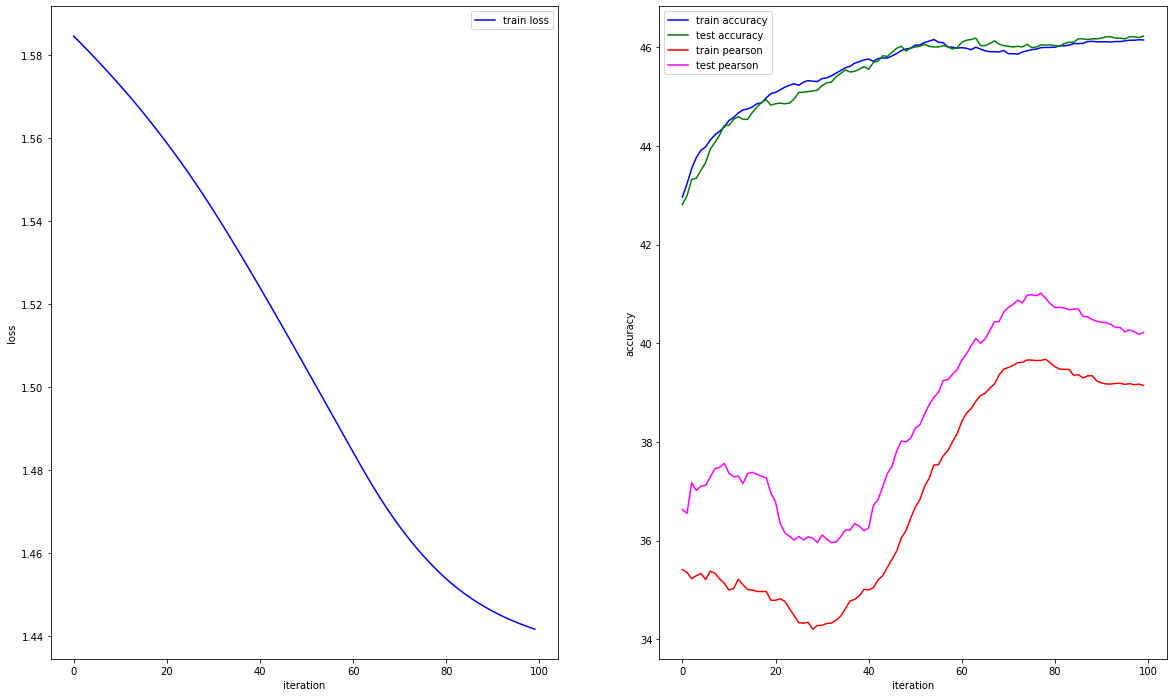

In [527]:
net.plot_train_history()

In [457]:
score = pearsonr(y_test_for_score, y_pred_proba)[0]
print("pearson score:", score)

pearson score: 0.006067339787395398
